In [14]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [15]:
import george
from george.kernels import MyDijetKernelSimp


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
from iminuit import Minuit

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

### Include data and toys

In [16]:
#Full bin centers (xvalO), counts (yvalO), bin width (xerrO), and bin low edges (xlowO) from ATLAS
xvalO = np.load("newoutputs/xvalO.npy") #outputs
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = np.load("newoutputs/xlowO.npy")

#Same, but with bins with zero counts removed. GP fits better without zero counts
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")

#10000 toys - created from smoothed data with Poisson noise
toyList = np.load("newoutputs/toyList.npy")
fixedHyperparams = np.load("newoutputs/fixedHyperparams.npy")


### 3 parameters fit function

In [17]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)

### Calculate z values. Shown on bottom panel of plots

In [18]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

### Poisson log likelihood

In [19]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

### remove zero count bins to use for GP fits

In [20]:
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

### Plot distribution of chi square on fit to toys

In [21]:
def makePrettyPlots_chi2(GPchi2, BKGchi2, title, drawchi2=False, xname=r'$\chi^{2}$/d.o.f.', label1 = "Gaussian Process", label2 = "Fit Function"):
    f, (ax1) = plt.subplots(1, figsize=(12,12), gridspec_kw = {'height_ratios':[1, 1]})
    f.suptitle(title, fontsize=40)

    lowx = min(min(GPchi2), min(BKGchi2))
    highx = max(max(GPchi2), max(BKGchi2))
    bins = np.linspace(lowx, highx, 100)
    
    hGP, _, _ =ax1.hist(GPchi2, bins=bins, alpha=0.7, color="g", label='Gaussian Process model')
    hBKG, _, _ =ax1.hist(BKGchi2, bins=bins, alpha=0.7, color='b', label="ad-hoc fit")
    ax1.tick_params(axis='y', labelsize=30)
    ax1.tick_params(axis='x', labelsize=30)
    ax1.set_xlabel(xname, fontsize=40)
    plt.xlim(0.4, 4)
    
    plt.legend(prop={'size':20})
    
    plt.show()

### Plot std of GP and 3 parameter fits to toys on top of ATLAS data

In [22]:
def makePrettyPlots_bkgFits(xs, ys, gpFits, bkgFits, title, ymax = 2e5):
    f, ax1 = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=40)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="ATLAS data")
    numFits = min(len(bkgFits), len(gpFits))

    
    ax1.fill_between(xs, np.mean(gpFits, axis=0)-np.std(gpFits, axis=0), np.mean(gpFits, axis=0)+np.std(gpFits, axis=0), facecolor='g', alpha=0.5, label="Gaussian Process model")
    ax1.fill_between(xs, np.mean(bkgFits, axis=0)-np.std(bkgFits, axis=0), np.mean(bkgFits, axis=0)+np.std(bkgFits, axis=0), facecolor='b', alpha=0.5, label="ad-hoc fit")
    
    ax1.legend(prop={'size':20})
    ax1.set_ylabel('Events per bin', fontsize=40)
    ax1.tick_params(axis='y', labelsize=30)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])


    ax1.tick_params(axis='x', labelsize=30)
    ax1.tick_params(axis='y', labelsize=30)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=40)

    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()


### Plot fits to toys on top of ATLAS data

In [23]:
def makePrettyPlots_oneBkgFits(xs, ys, bkgFits, title, c='b', ymax = 2e5):
    f, ax1 = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    for iFit, bkg in enumerate(bkgFits): 
        bkgPlot, =ax1.plot(xs, bkg, color=c, alpha=0.3, linewidth=1.0)

    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])


    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)

    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

### Poisson likelihood for 3 parameter fit functions

In [24]:
class logLike_3ff:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf

### Minuit minimization of 3 parameter fit functions. minimize negative log likelihood, return minimum negative log likelihood and fit parameters corresponding to minimum.

In [25]:
def fit_3ff(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * 6.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef=0.5,
                  p0 = init0, p1 = init1, p2 = init2,
                  error_p0 = 1e-2, error_p1 = 1e-1, error_p2 = 1e-1, 
                  limit_p0 = (0, 100.), limit_p1 = (-100., 100.), limit_p2 = (-100., 100.))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            if numRetries == 4: print "retry number = ", numRetries+1
            passedFit=True
        numRetries+=1
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args 
    if Print:
        print "min LL",minLLH
        print "best fit vals", best_fit_params
    return minLLH, best_fit_params

### mean function for GP - 3 parameter fit function. negative log likelihood for Gaussian Process - from george. Minuit minimzation for GP negative log likelihood. Return minimum log likelihood and hyperparameters and mean parameters corresponding to this minimum

In [29]:
def model_gp(params, t, xerr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

class logLike_gp:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, decay, length, power, sub, p0, p1, p2):
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf

def fit_gp_minuit(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0, 0, 0, 0, 0, 0, 0, 0)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1e6+1
        init1 = np.random.random() * 400.
        init2 = np.random.random() * 10. 
        init3 = np.random.random() * -100.
        init4 = np.random.random() * 650.
        init5 = np.random.random() * 1.
        init6 = np.random.random() * 1.
        init7 = np.random.random() * -1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef=0.5,
                  Amp = init0, decay = init1, length = init2, power = init3, sub = init4, 
                   p0 = init5, p1 = init6, p2 = init7,
                  error_Amp = 1, error_decay = 0.1, error_length = 0.1, error_power = 0.1, 
                   error_sub = 0.1, error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (100., 1e15), limit_decay = (1, 3000), limit_length = (0.1, 1000), 
                   limit_power = (10, 3000), limit_sub = (200, 2000), limit_p0 = (0,1000), 
                   limit_p1 = (0, 100), limit_p2 = (-100,100)) 


        fit = m.migrad()
        if fit[0]['is_valid']: 
            if numRetries == 4: print "retry number = ", numRetries+1
            passedFit=True
        numRetries+=1
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args 
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params

### Run 3 parameter fit and GP fit to toys. Calculate chi2 of fit

In [39]:
FFList = []
chi2FFList =[]
GPList = []
chi2GPList = []
for itoy, toy in enumerate(toyList[:100]):
    if not itoy%100: print itoy

    #3 parameter fit
    lnProb = logLike_3ff(xvalO,toy,xerrO)
    minimumLLH, best_fit_ff = fit_3ff(lnProb, False)
    ff = model_3param(xvalO, best_fit_ff, xerrO)
    zvals, chi2 = calcSignificance(toy, ff)
    if chi2/(len(toy)-1.-3.) > 10: 
        print "poor fit"
        continue
    chi2FFList.append(chi2/(len(toy)-1.-3.))
    FFList.append(ff)
    
    #GP fit
    ytoy, xtoy, xtoyerr = removeZeros(toy)
    lnProb = logLike_gp(xtoy,ytoy,xtoyerr)
    minimumLLH, best_fit_gp = fit_gp_minuit(lnProb, False)
    if np.isinf(minimumLLH): 
        print "inf"
        continue
    Amp, decay, length, power, sub, p0, p1, p2 = best_fit_gp
    kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
    gp = george.GP(kernel)
    gp.compute(xtoy, np.sqrt(ytoy))
    try:
        meanGPp, covGP = gp.predict(ytoy - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
    except:
        print "failed"
        continue
    meanGP = meanGPp + model_gp((p0,p1,p2),xvalO, xerrO) 

    zvals, chi2 = calcSignificance(toy, meanGP)
    if chi2/(len(toy)-1-len(best_fit_gp)) > 10: 
        print "poor fit"
        continue
    chi2GPList.append(chi2/(len(toy)-1-len(best_fit_gp)))
    GPList.append(meanGP)



0
retry number =  5


## FIGURE 2 and 3

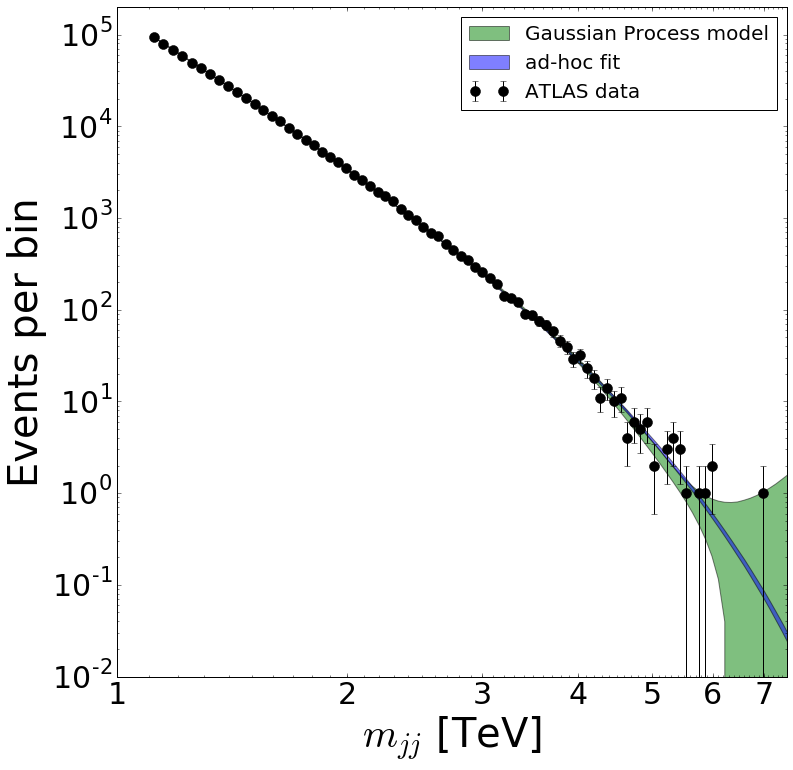

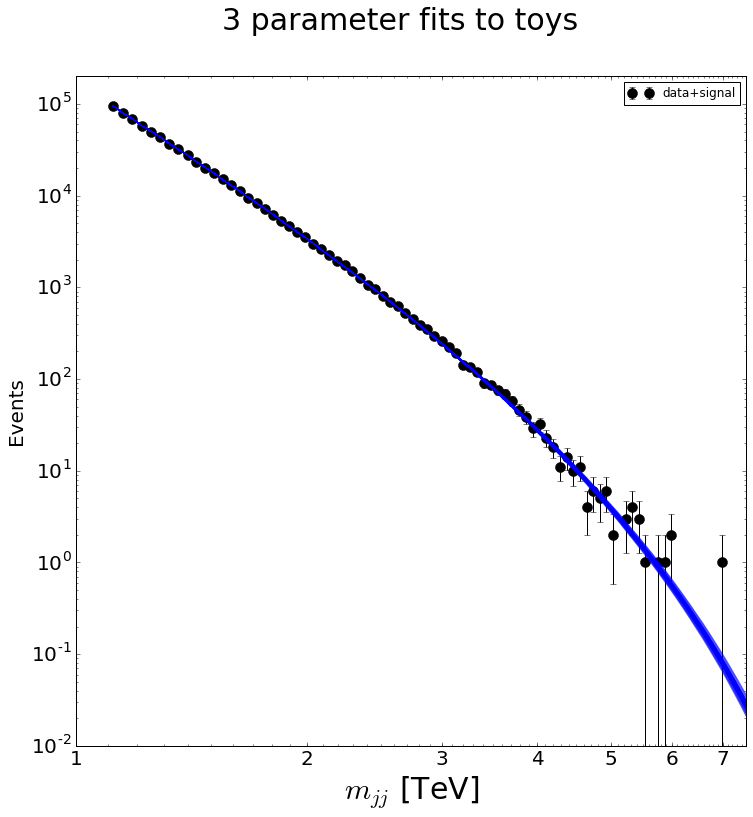

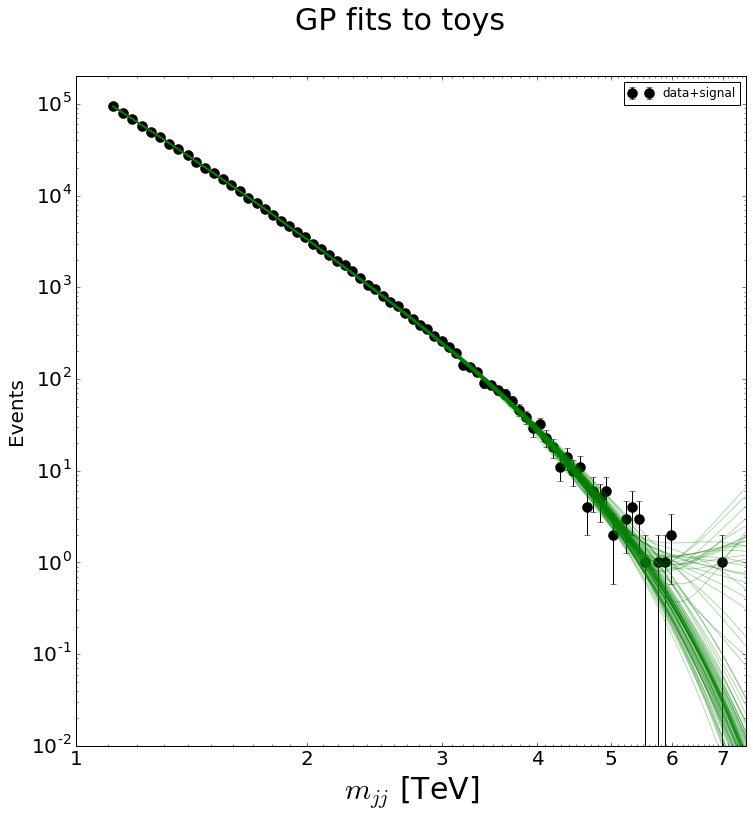

In [40]:
#label = "GP and 3 parameter fits to toys"
label=""
makePrettyPlots_bkgFits(xvalO, yvalO, GPList, FFList, label)
label = "3 parameter fits to toys"
makePrettyPlots_oneBkgFits(xvalO, yvalO, FFList, label)
label = "GP fits to toys"
makePrettyPlots_oneBkgFits(xvalO, yvalO, GPList, label, c="g")


### save (or load if previously run) chi2 of fits to toys

In [14]:
np.save("newoutputs/chi2_GP_fits.npy", chi2GPList)
np.save("newoutputs/chi2_3param_fits.npy", chi2FFList)
#chi2GPList=np.load("newoutputs/chi2_GP_fits.npy")
#chi2FFList=np.load("newoutputs/chi2_3param_fits.npy")

In [41]:
chi2FFList=np.array(chi2FFList)
chi2GPList=np.array(chi2GPList)

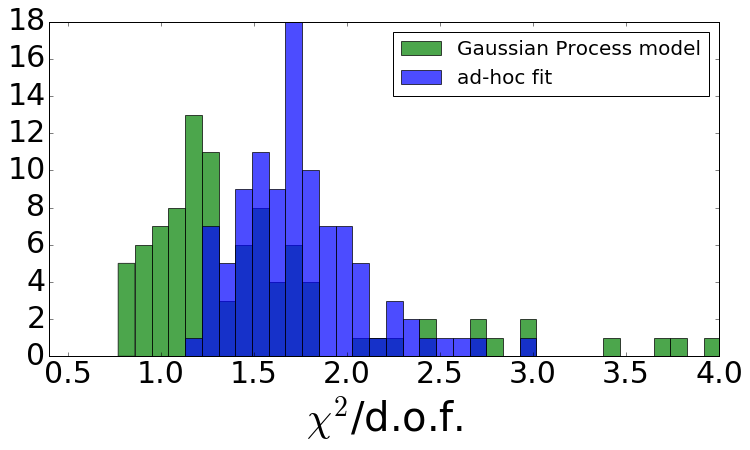

1.77439735976 1.74487711529


In [44]:
label = ""#"$\chi^{2}$"
makePrettyPlots_chi2([c for c in chi2GPList if c < 10], [c for c in chi2FFList if c < 10], label)
print np.mean(chi2GPList), np.mean(chi2FFList)
